Importing all necessary packkages


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [ ]:
nltk.download('stopwords')

Loading dataset from my drive

In [ ]:
URL = 'https://drive.google.com/file/d/1jligoR49f2PAOBE-P8ux5_1Q_y63C-I0/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
#df = pd.read_pickle(path)
df = pd.read_csv(path)
df.head()

Getting the number of rows and columns

In [ ]:
df.shape

Checking if any cells are empty

In [ ]:
df.isnull().sum()

In [ ]:
df["Rating"].value_counts() #Checks the rating values in case there is a unkown value

In [ ]:
df.loc[df["Review"] == ""] #Checks for empty review strings

In [ ]:
#Segregating and Encoding Positive, Neutral and Negative labels
pos = [4,5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1  
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

In [ ]:
#Analysing Positive, Neutral and Negative Reviews
fig = go.Figure([go.Bar(x=df.Sentiment.value_counts().index, y=df.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Preprocessing the data

In [ ]:
# removing Stopword,HTML Tags, Lower casing
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words("english"))
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" #List of punctuation to remove

def reviewParse(review):
    splitReview = review.split() #Split the review into words
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview]) #Takes the stubborn punctuation out
    return parsedReview #Returns the parsed review
  
def clean_review(review):
    clean_words = []
    splitReview = review.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    clean_review = " ".join(clean_words)
    return clean_review

df["Review"] = df["Review"].apply(reviewParse).apply(clean_review) #Parse all the reviews for their punctuation and add it into a new column

df.head() #Take a peek at the dataset

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms experience hotel monaco seattle goo...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [ ]:
docs = list(df['Review'])[:7000]

Transforming the data into a matrix 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)
#tfidf_vectorizer.get_feature_names()
X = tfidf_vectorizer_vectors.toarray()
Y = df['Sentiment'][:7000]
len(X[0])
print(tfidf_vectorizer_vectors)

  (0, 10424)	0.09099795176156944
  (0, 5039)	0.07898460426812665
  (0, 9877)	0.08686502690881456
  (0, 14421)	0.09649080763416126
  (0, 4137)	0.09352881713090914
  (0, 18477)	0.08085640696960425
  (0, 6163)	0.042408901749221954
  (0, 8164)	0.0531377340295593
  (0, 8206)	0.13105562823049124
  (0, 15450)	0.0849839601799433
  (0, 201)	0.13494652624539
  (0, 15963)	0.11192034040115667
  (0, 16486)	0.11813650070642641
  (0, 6048)	0.19877638715080057
  (0, 12150)	0.15161058826590362
  (0, 1209)	0.11280940652640904
  (0, 979)	0.18053016544671838
  (0, 9274)	0.1603801939157931
  (0, 9409)	0.10762766910005123
  (0, 8622)	0.11124902483984275
  (0, 6333)	0.1464481124444372
  (0, 15976)	0.1363827224105086
  (0, 10582)	0.06584532306202767
  (0, 6472)	0.10518635204063914
  (0, 2716)	0.1622839437426362
  :	:
  (6999, 1430)	0.043669217368277634
  (6999, 15814)	0.04946477248007903
  (6999, 10923)	0.08006313296612699
  (6999, 11319)	0.06978050106208412
  (6999, 1009)	0.04445900926038726
  (6999, 1424)	0

Graph after preprocessing

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

SEED=123

X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
fig = go.Figure([go.Bar(x=Y.value_counts().index, y=Y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Traing using different models

1.Gaussian Naive Bayes Classifier

In [ ]:

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,gnb.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,gnb.predict(X_test)),4)))

Training Accuracy score: 0.8704
Testing Accuracy score: 0.4529


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.30      0.36      0.33       249
     neutral       0.47      0.46      0.47       572
    negative       0.52      0.48      0.50       579

    accuracy                           0.45      1400
   macro avg       0.43      0.43      0.43      1400
weighted avg       0.46      0.45      0.46      1400



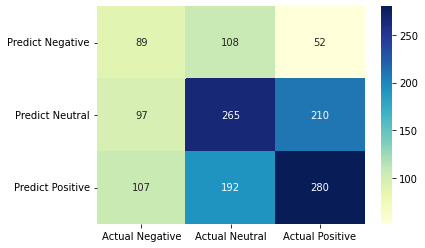

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Decision Tree Classifier

In [ ]:

dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.57


In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.59      0.55      0.57       249
     neutral       0.55      0.56      0.56       572
    negative       0.58      0.59      0.58       579

    accuracy                           0.57      1400
   macro avg       0.57      0.57      0.57      1400
weighted avg       0.57      0.57      0.57      1400



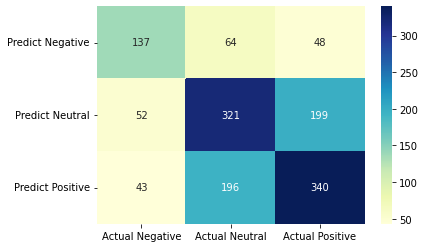

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Multilayer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
mlp.fit(X_train,y_train)
predmlp = mlp.predict(X_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

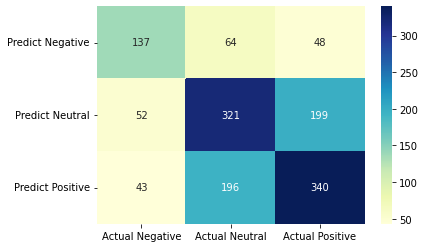

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Ann proved to be a better model

Testing the model on new text

In [ ]:
# POSITIVE REVIEW
df = ["hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bell building charm sturdiness, everytime walked bell men felt like coming home, secure, great single travelers, location fabulous, walk things pike market space needle.little grocery/drug store block away, today green, bravo, 1 double bed room room bed couch separated curtain, snoring mom slept curtain, great food nearby,  "][0]
print(df)
print("Actual Rating: ",5)
pr_t = tfidf_vectorizer.transform([df])
print("Predicted Rating:")
mlp.predict(pr_t)[0]